# Homework_2022_04_14

<font color=ff0000> 截止日期 4.18 中午 11:59</font>


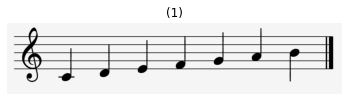

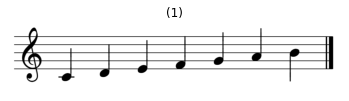

In [1]:
class Layer:
    def forward(self, x):
        raise NotImplementedError
    def backward(self, dy):
        raise NotImplementedError
    def _save_for_backward(self, obj):
        self._saved_obj = obj
    def _get_saved(self):
        saved = self._saved_obj
        del self._saved_obj
        return saved
    def optimize(self, lr):
        pass
    
class Relu(Layer):
    def forward(self, x):
        self._save_for_backward(x)
        return np.fmax(x, 0)
    def backward(self, dy):
        x = self._get_saved()
        return np.where(x>0,1,0)*dy
    
class Sigmoid(Layer):
    def forward(self, x):
        y = 1/(1+np.exp(-x))
        self._save_for_backward(y)
        return y
    
    def backward(self, dy):
        y=self._get_saved()
        return y*(1-y)*dy

class Softmax(Layer):
    def forward(self, x):
        c = np.max(x,axis=1,keepdims=True)
        x=np.exp(x-c)
        y=x/np.sum(x,axis=1,keepdims=True)
        self._save_for_backward(y)
        return y
    
    def backward(self, dy):
        y=self._get_saved()
        batchsize,n=y.shape
        S=np.broadcast_to(y.reshape(batchsize,1,n),(batchsize,n,n))
        local_grad = S*(np.eye(n)-S)
        dx=dy.reshape((batchsize,1,n))@local_grad
        dx=dx.reshape((batchsize, n))
        return dx
    
class FC(Layer):
    def __init__(self, in_size,out_size):
        self.in_size = in_size
        self.out_size = out_size
        self.w = np.empty((in_size,out_size),dtype=np.float)
        norm_init(self.w)
    
import matplotlib.pyplot as plt # plt 用于显示图片
import cv2 as cv # mpimg 用于读取图片
import numpy as np
from skimage.color import rgb2gray

def show_images(images, titles=None):
    n_ims = len(images)
    if titles is None:
        titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images, titles):
        a = fig.add_subplot(1, n_ims, n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.axis('off')
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()
    
img = cv.imread('/Users/guomingfei/python2022/notation.png')
original = img.copy()
gray = rgb2gray(img)
show_images([img])
show_images([gray])

## 1.1 对灰度图像做直方图均衡，然后用otsu阈值二值化。

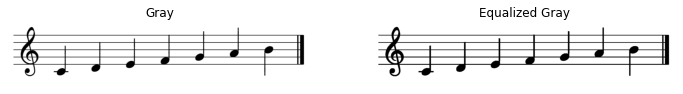

In [2]:
# TODO TODO TODO
from skimage.filters import threshold_otsu

def histogram_equalization(image, number_bins=256):
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize


    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

equalized_gray = histogram_equalization(gray)
show_images([gray, equalized_gray], ['Gray', 'Equalized Gray'])


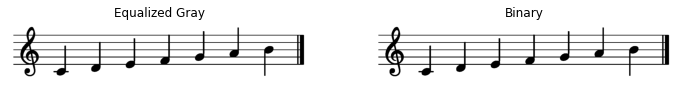

In [3]:
# TODO TODO TODO
def get_thresholded(img, thresh):
    return 1*(img > thresh)

bin_img = get_thresholded(equalized_gray, threshold_otsu(equalized_gray))
show_images([equalized_gray, bin_img], ['Equalized Gray', 'Binary'])


## 1.2 去掉谱子中的线。

In [4]:
def rle_encode(arr):
    x = np.copy(arr)
    first_dismatch = np.array(x[1:] != x[:-1])
    distmatch_positions = np.append(np.where(first_dismatch), len(x)-1)
    rle = np.diff(np.append(-1, distmatch_positions))
    values = [x[i] for i in np.cumsum(np.append(0, rle))[:-1]]
    return rle, values

def hv_rle(img, axis=1):
    # 可以理解为将 AACCCBBBBBAAAAFFFFFFFF 表示 A2C3B5A4F8
    # 对于黑白图像，可以方便的表示黑白间隔的长度
    rle, values = [], []

    if axis == 1:
        for i in range(img.shape[1]):
            col_rle, col_values = rle_encode(img[:, i])
            rle.append(col_rle)
            values.append(col_values)
    else:
        for i in range(img.shape[0]):
            row_rle, row_values = rle_encode(img[i])
            rle.append(row_rle)
            values.append(row_values)

    return rle, values

def calculate_pair_sum(arr):
    if len(arr) == 1:
        return list(arr)
    else:
        res = [arr[i] + arr[i + 1] for i in range(0, len(arr) - 1, 2)]
        if len(arr) % 2 == 1:
            res.append(arr[-2] + arr[-1])
        return res
    
def get_most_common(rle):
    pair_sum = [calculate_pair_sum(col) for col in rle]

    flattened = []
    for col in pair_sum:
        flattened += col

    most_common = np.argmax(np.bincount(flattened))
    return most_common

rle, vals = hv_rle(bin_img)
# 根据rle黑白间隔的长，计算二值图像每行中黑色和白色的和，并找出最普遍的结果
# 可以认为这个最普遍的结果是五线谱的线间距
most_common = get_most_common(rle)
print(most_common)

32


In [5]:
# 已经计算出五线谱的线间距之后，统计黑白部分各占多少
from collections import Counter

def most_common_bw_pattern(arr, most_common):
    if len(arr) == 1:
        return []
    else:
        res = [(arr[i], arr[i + 1]) for i in range(0, len(arr) - 1, 2)
               if arr[i] + arr[i + 1] == most_common]

        if len(arr) % 2 == 1 and arr[-2] + arr[-1] == most_common:
            res.append((arr[-2], arr[-1]))
        return res
    
def calculate_thickness_spacing(rle, most_common):
    bw_patterns = [most_common_bw_pattern(col, most_common) for col in rle]
    bw_patterns = [x for x in bw_patterns if x]  # Filter empty patterns

    flattened = []
    for col in bw_patterns:
        flattened += col

    pair, count = Counter(flattened).most_common()[0]

    line_thickness = min(pair)
    line_spacing = max(pair)

    return line_thickness, line_spacing

thickness, spacing = calculate_thickness_spacing(rle, most_common)
# 分别指黑色部分和白色部分
print(thickness, spacing)

3 29


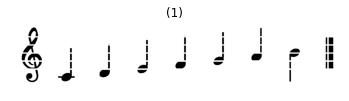

In [9]:
# TODO TODO TODO
# 用一个只包含线的滑窗去对齐原图（前后稍微移动取得卷积最大）后做减法。
# 然后再用膨胀~腐蚀（闭操作）对图像加工一下。
# 只去掉线的话会出现音符被分开的情况，所以去掉线之后需要对图像进行膨胀。
# https://zhuanlan.zhihu.com/p/110330329

from skimage.morphology import binary_opening

from scipy import signal

img_with_staff = bin_img
img_with_staff = np.array(img_with_staff,dtype=np.uint8)
template = np.zeros((thickness, 100),dtype=np.uint8)
arr = signal.convolve2d(1-img_with_staff, 1-template, 'same')

loc = np.where(arr.T[300] > 180)[0]
img_no_staff = img_with_staff
for i in loc:
    img_no_staff[i:i+thickness][:] = np.ones_like(img_no_staff[i:i+thickness][:])
show_images([img_no_staff])    

# no_staff_img = binary_opening(img_no_staff, np.ones((10, 1)))
# show_images([no_staff_img])

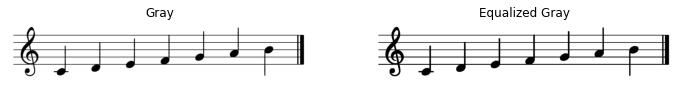

In [8]:
def histogram_equalization(gray):
    new= np.interp(gray,[gray.min(),gray.max()],[0,255]).astype(np.uint8)
    equalized=cv.equalizeHist(new)
    return equalized
equalized_gray = histogram_equalization(gray)
show_images([gray, equalized_gray], ['Gray', 'Equalized Gray'])


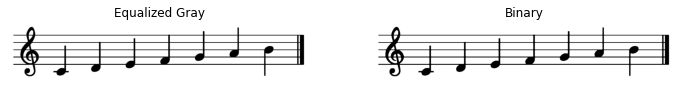

In [11]:
reblurred=cv.GaussianBlur(equalized_gray,(5,5),0)
ret1, bin_img = cv.threshold(reblurred, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU) 
show_images([equalized_gray, bin_img], ['Equalized Gray', 'Binary'])

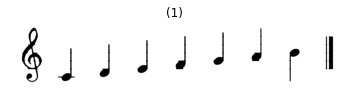

In [12]:
kernel = np.ones((3, 3), dtype=np.uint8) 
# kernel=np.ones((6,1),dtype=np.uint8)
dilate=cv.dilate(bin_img,kernel,iterations=2)
no_staff_img=cv.erode(dilate, kernel, iterations=1)
show_images([no_staff_img])

In [18]:
print(no_staff_img)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


In [6]:
# img_no_staff=1-img_no_staff
kernel = np.ones((5, 2), dtype=np.uint8)
dilation = cv.dilate(img_no_staff,kernel,iterations = 1)
show_images([dilation])
erosion = cv.erode(img_no_staff,kernel,iterations = 3)
show_images([erosion])
opening = cv.morphologyEx(img_no_staff, cv.MORPH_OPEN, kernel)
show_images([opening])
closing = cv.morphologyEx(img_no_staff, cv.MORPH_CLOSE, kernel)
show_images([closing])

NameError: name 'img_no_staff' is not defined

In [7]:
# huachuang = np.zeros((1, bin_img.shape[1])).astype(np.uint8)
# show_images([huachuang])
# 
# for _ in range(17):
#     result = cv.matchTemplate(bin_img, huachuang, cv.TM_SQDIFF)
#     min_val,max_val,min_loc,max_loc=cv.minMaxLoc(result)
#     top_left=min_loc
#     h,w=huachuang.shape[:2]
#     bottom_right=(top_left[0]+w,top_left[1]+h)
#     bin_img[top_left[1]:bottom_right[1], :] = np.ones_like(huachuang) * 255
#     
# show_images([bin_img])

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-39p1qqfs/opencv/modules/imgproc/src/templmatch.cpp:1163: error: (-215:Assertion failed) (depth == CV_8U || depth == CV_32F) && type == _templ.type() && _img.dims() <= 2 in function 'matchTemplate'


## 1.3 取出音符，算hog特征。

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
10


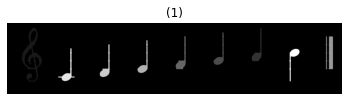

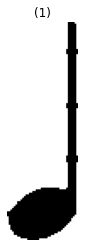

In [20]:
# 取出音符
from skimage.measure import label, regionprops
bw = 1-no_staff_img
print(no_staff_img)
print(bw)
label_img = label(bw, background=2)
show_images([label_img])

boundary = []
for region in regionprops(label_img):
    if region.area >= 100:
        boundary.append(region.bbox)

boundary = sorted(boundary, key=lambda b: b[1])

components = []
for bbox in boundary:
    minr, minc, maxr, maxc = bbox
    components.append(no_staff_img[minr:maxr, minc:maxc])

show_images([components[3]])
print(len(components))



In [12]:
# TODO TODO TODO
target_img_size = (300, 1300)

def extract_hog_features(img):
    img = cv.resize(img, target_img_size)
    win_size = (100, 100)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)

    block_size = (block_size_in_cells[1] * cell_size[1],
                  block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv.HOGDescriptor(win_size, block_size,
                            block_stride, cell_size, nbins)
    h = hog.compute(img)
    return h.flatten()

In [13]:
comp_label = [0,1,1,1,1,1,1,1,2,2]

def img_resize_to_target_white(image,h,w):
    target = np.ones((w,h),dtype=np.uint8)*255
    (image_h,image_w)=image.shape
    for i in range(image_w,2*image_w):
        for j in range(image_h,2*image_h):
            target[i][j]=image[j-image_h][i-image_w]
    return target.T

def rotate_image(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)

    # perform the rotation
    M = cv.getRotationMatrix2D(center, angle, scale)
    rotated = cv.warpAffine(image, M, (w, h),borderValue=(255,255,255))

    # return the rotated image
    return rotated

datas=[]
labels=[]

label_idx=0
for comp in components:
    comp = np.array(comp,dtype=np.uint8)*255
    datas.append(comp.flatten())
    labels.append(comp_label[label_idx])
    label_idx+=1
    
label_idx=0
for comp in components:
    comp = np.array(comp,dtype=np.uint8)*255#在
    rot = rotate_image(comp, angle=45, scale=0.4)
    datas.append(rot.flatten())
    labels.append(comp_label[label_idx])
    label_idx+=1
    
    
label_idx=0
for comp in components:
    comp = np.array(comp,dtype=np.uint8)*255#在
    rot = rotate_image(comp, angle=90, scale=0.3)
    datas.append(rot.flatten())
    labels.append(comp_label[label_idx])
    label_idx+=1
    

In [14]:
hog_features = []
for data in datas:
    feature_data = (255*(1 - data)).astype(np.uint8)
    hog_feature = extract_hog_features(feature_data)
    hog_features.append(hog_feature)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=1)

clf = MultinomialNB()
clf.fit(X_train, y_train)

## 2.1 （附加1）LoG对原始灰度图gray做检测。

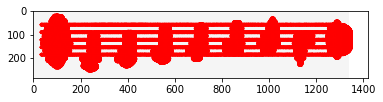

In [21]:
# TODO TODO TODO
def LoG(sigma):
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

k = 1.414
sigma = 1.0
def LoG_convolve(img):
    log_images = [] 
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y 
        filter_log = LoG(sigma_1) 
        image = cv.filter2D(img,-1,filter_log) 
        image = np.pad(image,((1,1),(1,1)),'constant') 
        image = np.square(image) 
        log_images.append(image)
    log_image_np = np.array([i for i in log_images])
    return log_image_np

LoG_gray = LoG_convolve(gray)

def detect_blob(log_image_np):
    co_ordinates = [] 
    (h,w) = gray.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] 
            result = np.amax(slice_img) 
            if result >= 0.03: 
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) 
    return co_ordinates

co_ordinates = list(set(detect_blob(LoG_gray)))

fig, ax = plt.subplots()
ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=1, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

## 2.2 （附加2）通过变换增加数据，训练一个可以识别音符/谱号/终止符的分类器。

In [116]:


from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
new_datas = []
for data in datas:
    new_datas.append(data.tolist())
X_train, X_test, y_train, y_test = train_test_split(new_datas, labels, test_size=0.2, random_state=1)
clf = GaussianNB()
# clf.fit(np.array(X_train), y_train)